#Multivariate LSTM model

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import mysql.connector
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


Constructing the dataset

In [2]:
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="yahoonet",
    database="AIProject"
)

def make_multivariate_sequences(array, n_steps):
    """array shape: (timesteps, n_features)"""
    X, y = [], []
    for i in range(len(array)-n_steps):
        X.append(array[i:i+n_steps,:])      # n_steps x n_features
        y.append(array[i+n_steps,0])        # predict market_value next
    return np.array(X), np.array(y)

def make_multivariate_multistep(array, n_steps, n_future=3):
    """
    array shape: (timesteps, n_features)
    n_steps = how many past windows
    n_future = how many steps ahead to predict (e.g., next 3 windows)
    """
    X, y = [], []
    for i in range(len(array)-n_steps-n_future+1):
        X.append(array[i:i+n_steps, :])
        y.append(array[i+n_steps:i+n_steps+n_future, 0])  # future market_value only
    return np.array(X), np.array(y)

# --- Load the merged time series ---
# (Here df_t is the transfer history with date & market_value)
# (df_f is the player_features table with static columns)

df_t = pd.read_sql("SELECT transfermarkt_id, transfer_date, market_value FROM player_transfer_history ORDER BY transfermarkt_id, transfer_date", db)
df_f = pd.read_sql("SELECT * FROM player_features", db)

# Merge static features onto each time row
df = df_t.merge(df_f[["player_id","total_injuries","sentiment_mean","avg_cards_per_match","avg_days_out","recent_injury","days_since_last_injury","season_id","minutes_played","shots_per90","pressures_per90"]],
                left_on="transfermarkt_id", right_on="player_id", how="left")

# Sort by time per player
df = df.sort_values(["transfermarkt_id","transfer_date"])

df.head()

n_steps = 3
n_future = 3
X_list, y_list, player_index = [], [], []

for pid, group in df.groupby("transfermarkt_id"):
    # Select columns for features
    features = group[["market_value","total_injuries","sentiment_mean","avg_cards_per_match","avg_days_out","recent_injury","days_since_last_injury","season_id","minutes_played","shots_per90","pressures_per90"]].fillna(0).values
    
    # Scale per player for all features
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(features)

    #Xp, yp = make_multivariate_sequences(scaled, n_steps)
    Xp, yp = make_multivariate_multistep(scaled, n_steps, n_future)
    if len(Xp)==0:
        continue
    X_list.append(Xp)
    y_list.append(yp)
    player_index.extend([pid]*len(yp))

# Stack across all players
#X = np.vstack(X_list)   # shape: (samples, n_steps, n_features)
#y = np.concatenate(y_list)  # shape: (samples,)

X = np.vstack(X_list)   # (samples, n_steps, n_features)
y = np.vstack(y_list)   # (samples, n_future)



C:\Users\Himanshu Saxena\AppData\Local\Temp\ipykernel_26820\1035311267.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_t = pd.read_sql("SELECT transfermarkt_id, transfer_date, market_value FROM player_transfer_history ORDER BY transfermarkt_id, transfer_date", db)
C:\Users\Himanshu Saxena\AppData\Local\Temp\ipykernel_26820\1035311267.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_f = pd.read_sql("SELECT * FROM player_features", db)


Check for missing values

In [3]:
print(df.isnull().sum())

transfermarkt_id          0
transfer_date             0
market_value              0
player_id                 0
total_injuries            0
sentiment_mean            0
avg_cards_per_match       0
avg_days_out              0
recent_injury             0
days_since_last_injury    0
season_id                 0
minutes_played            0
shots_per90               0
pressures_per90           0
dtype: int64


LSTM Building

Epoch 1/50


C:\Users\Himanshu Saxena\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1454 - val_loss: 0.1321
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1051 - val_loss: 0.1257
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1025 - val_loss: 0.1235
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0996 - val_loss: 0.1217
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0972 - val_loss: 0.1177
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0961 - val_loss: 0.1180
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0950 - val_loss: 0.1187
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0948 - val_loss: 0.1194
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0949 - val_loss: 0.1194
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0936 - val_loss: 0.1152
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0947 - val_loss: 0.1195
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0939 - val_loss: 0.1146


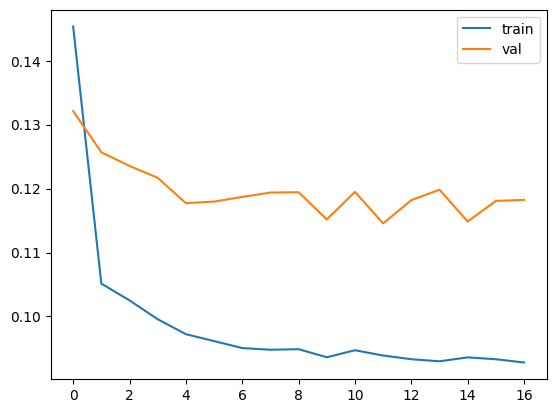

In [4]:
n_features = X.shape[2]

model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(n_future))   # output n_future steps
model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, shuffle=True, callbacks=[es])
#history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, shuffle=True)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()



Training + Loss curves

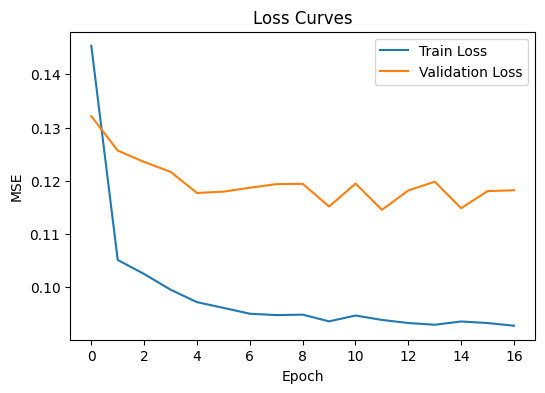

In [5]:
# Plot loss curves
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('Loss Curves')
plt.show()


RMSE

In [6]:
# Evaluate RMSE on validation set

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(n_future))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val,y_val))

y_pred = model.predict(X_val)

# compute RMSE for each horizon
rmse_per_step = np.sqrt(np.mean((y_val - y_pred)**2, axis=0))
print("RMSE per forecast step:", rmse_per_step)


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1541 - val_loss: 0.1058
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1110 - val_loss: 0.1021
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1078 - val_loss: 0.0992
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1042 - val_loss: 0.0973
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1025 - val_loss: 0.0958
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1009 - val_loss: 0.0954
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1006 - val_loss: 0.0949
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0995 - val_loss: 0.0967
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0997 - val_loss: 0.0948
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0995 - val_loss: 0.0948
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0988 - val_loss: 0.0946
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0992 - val_lo

Prediction

--------------------------------
Predicting for player ID: 28396
--------------------------------
[   8198    8198    8198 ... 1145504 1145504 1190411]
[False False False ... False False False]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
True values: [[0.         0.13333333 1.        ]
 [0.13333333 1.         0.66666667]
 [1.         0.66666667 0.5       ]
 [0.66666667 0.5        0.5       ]
 [0.5        0.5        0.13333333]
 [0.5        0.13333333 0.13333333]
 [0.13333333 0.13333333 0.05333333]]
Predicted values: [0.09855366 0.24916583 0.43393388 0.09855366 0.24916583 0.43393388
 0.27858025 0.390491   0.5330237  0.8435371  0.78707    0.74068755
 0.6403916  0.62515765 0.6168444  0.45037144 0.4308805  0.45885208
 0.50871617 0.5467354  0.61585975]
--------------------------------
--------------------------------
    transfermarkt_id transfer_date  market_value  player_id  total_injuries  \
20             28396    2003-07-01             0      28396              16   
21             28396   

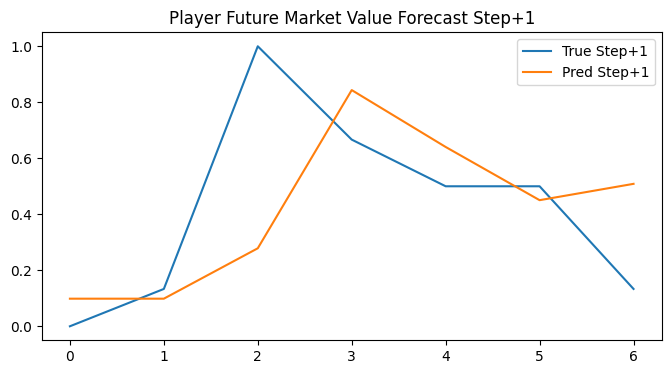

----------------Step + 2----------------


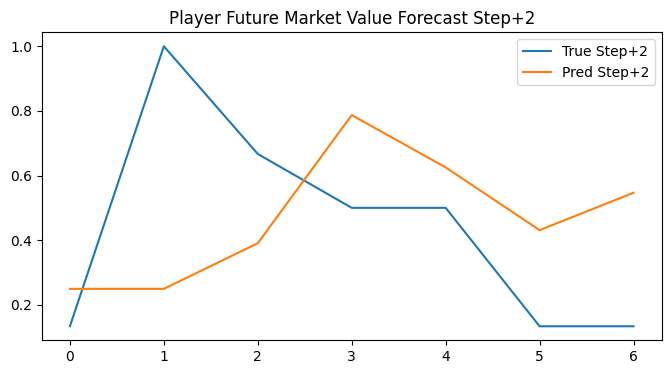

----------------xxxxx----------------
--------------------------------
Predicting for player ID: 8198
--------------------------------
[   8198    8198    8198 ... 1145504 1145504 1190411]
[ True  True  True ... False False False]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
True values: [[0.   0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.6 ]
 [0.   0.6  1.  ]
 [0.6  1.   0.45]
 [1.   0.45 0.2 ]
 [0.45 0.2  0.2 ]]
Predicted values: [0.09855366 0.24916583 0.43393388 0.09855366 0.24916583 0.43393388
 0.09855366 0.24916583 0.43393388 0.09855366 0.24916583 0.43393388
 0.09855366 0.24916583 0.43393388 0.7027891  0.69908535 0.7120739
 0.77353406 0.74374735 0.7244642 ]
--------------------------------
--------------------------------
    transfermarkt_id transfer_date  market_value  player_id  total_injuries  \
3               8198    1995-07-01             0       8198              29   
4               8198    1996-07-01             0       8198              29   
5               8198    1997-07-01 

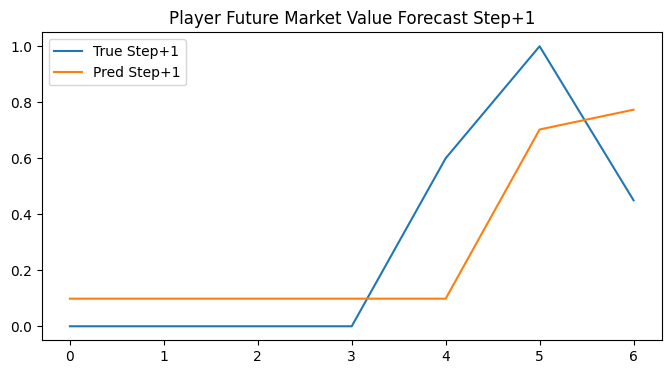

----------------Step + 2----------------


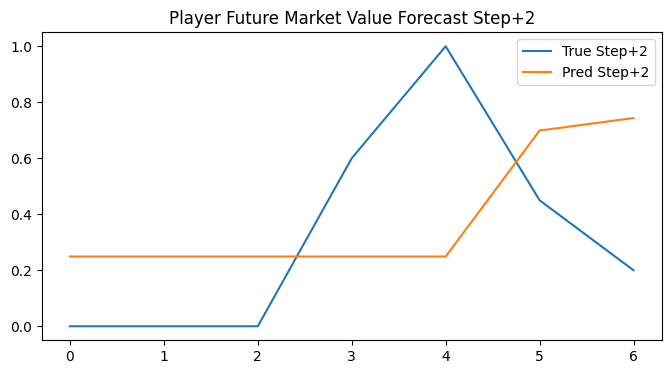

----------------xxxxx----------------
--------------------------------
Predicting for player ID: 49499
--------------------------------
[   8198    8198    8198 ... 1145504 1145504 1190411]
[False False False ... False False False]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
True values: [[0.         0.21666667 0.5       ]
 [0.21666667 0.5        0.66666667]
 [0.5        0.66666667 1.        ]
 [0.66666667 1.         0.6       ]
 [1.         0.6        0.26666667]
 [0.6        0.26666667 0.26666667]]
Predicted values: [0.09855366 0.24916583 0.43393388 0.09855366 0.24916583 0.43393388
 0.3776019  0.46663272 0.5838161  0.63791203 0.6858324  0.7517247
 0.69199604 0.73250604 0.7830947  0.8139777  0.77529407 0.75514346]
--------------------------------
--------------------------------
    transfermarkt_id transfer_date  market_value  player_id  total_injuries  \
50             49499    2004-07-01             0      49499              17   
51             49499    2005-07-01             0      494

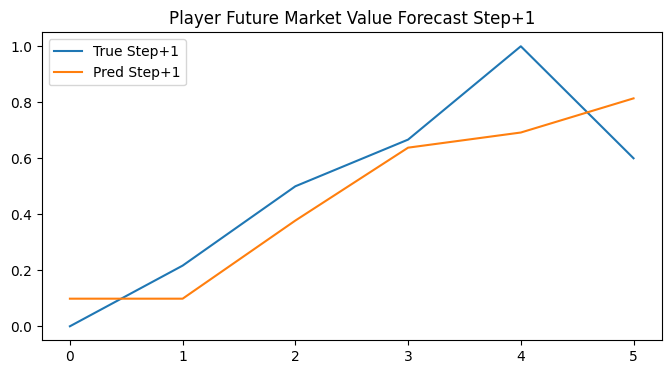

----------------Step + 2----------------


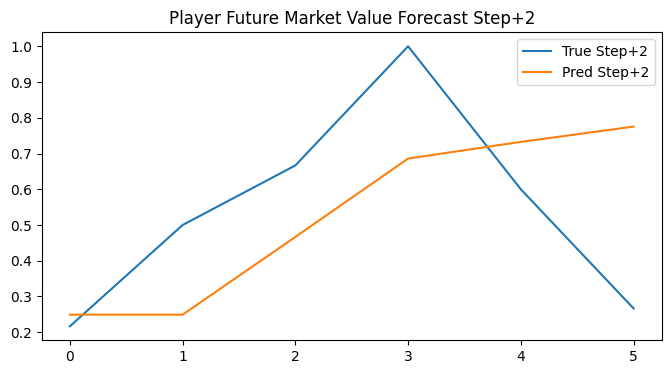

----------------xxxxx----------------
--------------------------------
Predicting for player ID: 33812
--------------------------------
[   8198    8198    8198 ... 1145504 1145504 1190411]
[False False False ... False False False]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
True values: [[1.   0.72 0.72]
 [0.72 0.72 0.6 ]
 [0.72 0.6  0.18]
 [0.6  0.18 0.18]
 [0.18 0.18 0.12]
 [0.18 0.12 0.07]]
Predicted values: [0.63733983 0.65600777 0.6942606  0.78639674 0.75976074 0.7441255
 0.67941934 0.66172713 0.6620132  0.62456    0.56071436 0.54363775
 0.5843252  0.5873954  0.62068003 0.17399606 0.27285638 0.40467224]
--------------------------------
--------------------------------
    transfermarkt_id transfer_date  market_value  player_id  total_injuries  \
32             33812    2003-08-20             0      33812               2   
33             33812    2005-01-17             0      33812               2   
34             33812    2006-02-08       1250000      33812               2   
35     

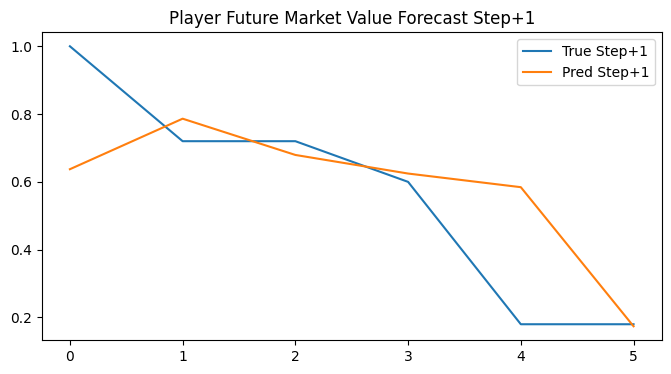

----------------Step + 2----------------


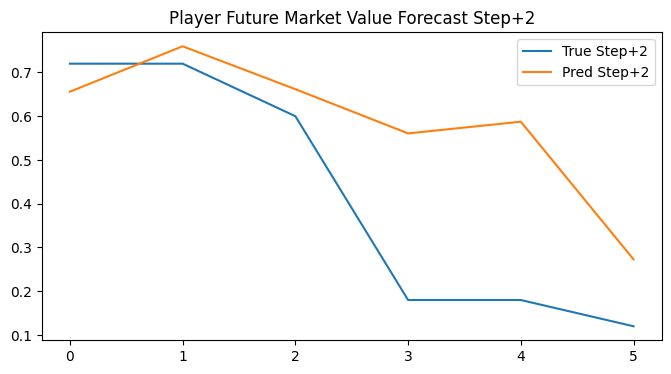

----------------xxxxx----------------
Exiting prediction loop.


In [7]:
player_id = 28396
default_value = f"{player_id}"
user_input = default_value
while user_input.isdigit(): 
    user_input = input(f"Enter something (default: {default_value}).\n Enter any non-numeric value (eg:Stop) to stop predictions: ") or default_value
    if user_input.isdigit():
        pid = int(user_input)
    else:
        print("Exiting prediction loop.")
        break

    if pid not in df.transfermarkt_id.values:
        print("--------------------------------")
        print("Player ID not found in data. Please try another ID.")
        print("--------------------------------") 
        #exit()
    else:
        try:
            print("--------------------------------")
            print("Predicting for player ID:", pid)
            print("--------------------------------")
            print(np.array(player_index))
            mask = np.array(player_index)==pid
            print(mask)
            X_player = X[mask]
            y_true = y[mask]
            y_pred = model.predict(X_player)
            print("True values:", y_true)
            print("Predicted values:", y_pred.flatten())
            print("--------------------------------")
            selected_rows = df.loc[df['transfermarkt_id'] == pid]
            print("--------------------------------")
            print(selected_rows)
            print("----------------Step + 1----------------")
            plt.figure(figsize=(8,4))
            plt.plot(y_true[:,0], label='True Step+1')
            plt.plot(y_pred[:,0], label='Pred Step+1')
            plt.legend(); plt.title("Player Future Market Value Forecast Step+1")
            plt.show()
            print("----------------Step + 2----------------")
            plt.figure(figsize=(8,4))
            plt.plot(y_true[:,1], label='True Step+2')
            plt.plot(y_pred[:,1], label='Pred Step+2')
            plt.legend(); plt.title("Player Future Market Value Forecast Step+2")
            plt.show()
            print("----------------xxxxx----------------")
        except Exception as e:
            print("Error during prediction:", e)
            print("--------------------------------")
